In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gymnasium as gym
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from tqdm.notebook import tqdm

## Lorenz System

In [2]:
initial_point = np.array([10.61098536,  5.87720862, 34.48052002])
params = [10, 28, 8/3]
dt = 0.001
n_samples = 100000

def dpdt(point, params=params): #position

    x,y,z = point
    sig, rho, beta = params
    
    new_x = y*dt*sig + x*(1-dt*sig)
    new_y = x*dt*(rho-z) + y*(1-dt)
    new_z = x*y*dt + z*(1-dt*beta)
    return np.array([new_x, new_y, new_z])

# calculate trajectory
positions = []
positions.append(initial_point)

# your dataset
for i in range(n_samples):
    positions.append(dpdt(positions[-1]))

In [3]:
positions = np.stack(positions, dtype=np.float32)
positions = torch.from_numpy(positions)
positions.shape

torch.Size([100001, 3])

In [4]:
# Max-Min Normalizing - squishes everything between 0 and 1
max_value = positions.max()
min_value = positions.min()
positions = (positions - min_value) / (max_value - min_value)

## Helper Functions

In [5]:
def create_minibatches(batch_size, *arrays):
    n = len(arrays[0]) # assume all arrays have same length
    assert all(len(arr) == n for arr in arrays), "All input arrays must have the same length"


    # shuffle indices
    indices = np.random.permutation(n)
    shuffled_arrays = [arr[indices] for arr in arrays]

    for start_ind in range(0, n, batch_size):
        end_ind = min(start_ind + batch_size, n)
        yield tuple(arr[start_ind:end_ind] for arr in shuffled_arrays)

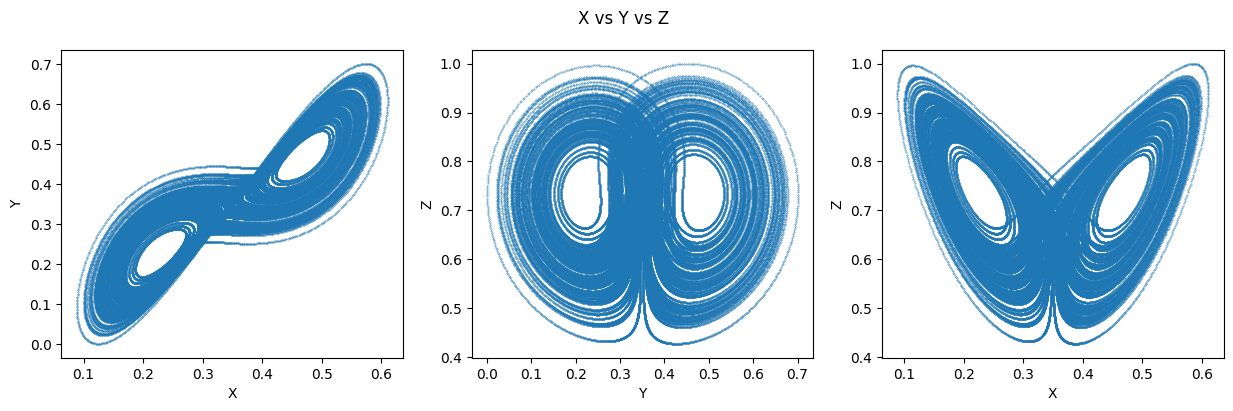

In [6]:
def plot_xyz(data, title):
    figure, axs = plt.subplots(1, 3, figsize=(15, 4))
    figure.suptitle(title)

    axs[0].scatter(data[:,0], data[:,1], s=0.1)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")

    axs[1].scatter(data[:,1], data[:,2], s=0.1)
    axs[1].set_xlabel("Y")
    axs[1].set_ylabel("Z")

    axs[2].scatter(data[:,0], data[:,2], s=0.1)
    axs[2].set_xlabel("X")
    axs[2].set_ylabel("Z")

plot_xyz(positions, "X vs Y vs Z")

In [7]:
def compare_trajectories(data1, data2, suptitle, data1_label, data2_label):
    figure, axs = plt.subplots(1, 3, figsize=(15, 4))
    figure.suptitle(suptitle)

    axs[0].scatter(data1[:,0], data1[:,1], s=0.1, c="blue", label=data1_label)
    axs[0].scatter(data2[:,0], data2[:,1], s=0.1, c="red", label=data2_label)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend(loc="upper right")

    axs[1].scatter(data1[:,1], data1[:,2], s=0.1, c="blue", label=data1_label)
    axs[1].scatter(data2[:,1], data2[:,2], s=0.1, c="red", label=data2_label)
    axs[1].set_xlabel("Y")
    axs[1].set_ylabel("Z")
    axs[1].legend(loc="upper right")

    axs[2].scatter(data1[:,0], data1[:,2], s=0.1, c="blue", label=data1_label)
    axs[2].scatter(data2[:,0], data2[:,2], s=0.1, c="red", label=data2_label)
    axs[2].set_xlabel("X")
    axs[2].set_ylabel("Z")
    axs[2].legend(loc="upper right")

## Resnet

In [82]:
class RES_DNN(nn.Module):

    def __init__(self):
        super().__init__()
    
        self.model = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, state):
        return self.model(state)

In [83]:
test = RES_DNN().to("cuda")
summary(test, (3,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             128
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 3]              99
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [105]:
def train_dnn(model, data, num_epochs, batch_size, lr, multistep=False):
    losses = []
    loss_fn = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    t0 = data[:-2]
    t1 = data[1:-1]
    t2 = data[2:]

    for epoch in tqdm(range(num_epochs)):
        for b_t0, b_t1, b_t2 in create_minibatches(batch_size, t0, t1, t2):
            b_t0 = b_t0 + torch.randn(b_t0.shape) * 0.01

            b_preds = model(b_t0)
            loss = loss_fn(b_t1, b_preds)

            if multistep:
                b_preds = model(b_preds)
                loss + loss_fn(b_t2, b_preds)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
    
    return losses

In [111]:
model = RES_DNN()
losses = train_dnn(model, positions, 10, 64, 1e-4, False)

  0%|          | 0/10 [00:00<?, ?it/s]

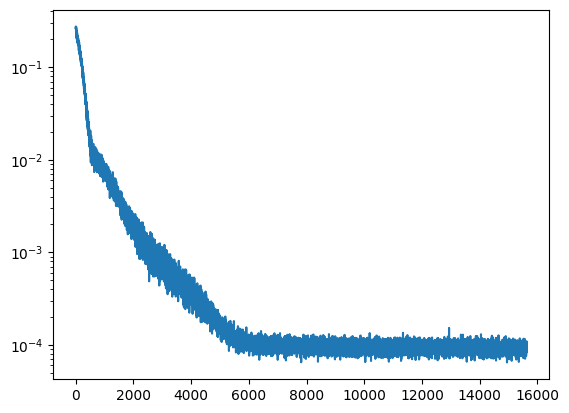

In [112]:
plt.plot(losses)
plt.yscale("log")

## Test Resnet

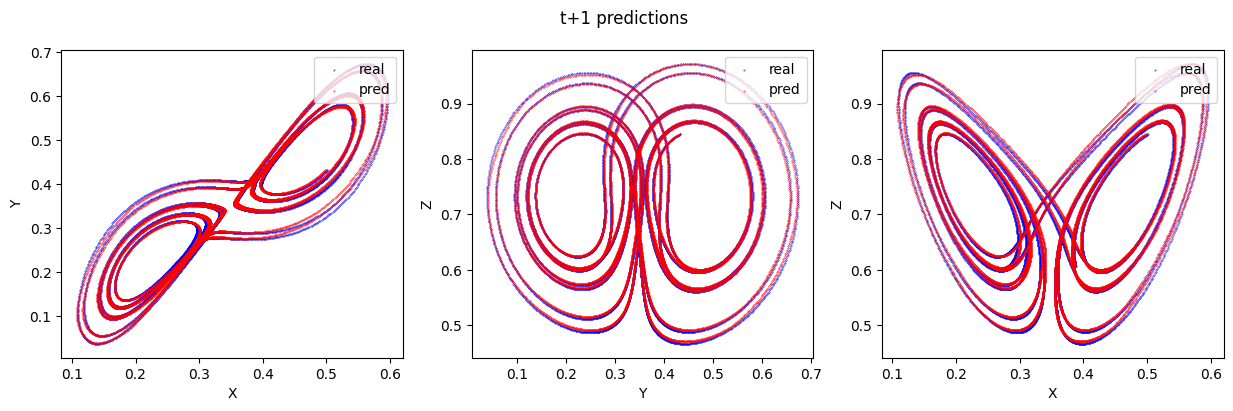

In [113]:
preds = model(positions).detach()
compare_trajectories(positions[:10000], preds[:10000], "t+1 predictions", "real", "pred")

In [36]:
# Starting from the given states, what is the models predictions for 50 time steps from each of those steps
def t_plus_n(model, n, display_n_samples, compare=True):

    with torch.no_grad():
        preds = model(positions[:-n])

        for i in range(min(n-1, display_n_samples)):
            preds = model(preds)

    if compare:
        compare_trajectories(positions[:display_n_samples], preds[:display_n_samples], f"t+{n} predictions", "real", "pred")
    else:
        plot_xyz(preds[:display_n_samples], f"t+{n} predictions")
    
    return preds

In [74]:
# display_n_samples = 500
# _ = t_plus_n(model, 50, display_n_samples)
# _ = t_plus_n(model, 150, display_n_samples)
# _ = t_plus_n(model, 500, display_n_samples)

In [39]:
def n_step_rollout(model, n, start_state):
    input = start_state
    preds = []

    with torch.no_grad():
        for i in tqdm(range(n)):
            input = model(input)

            preds.append(input)

    preds = torch.stack(preds)
    return preds

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

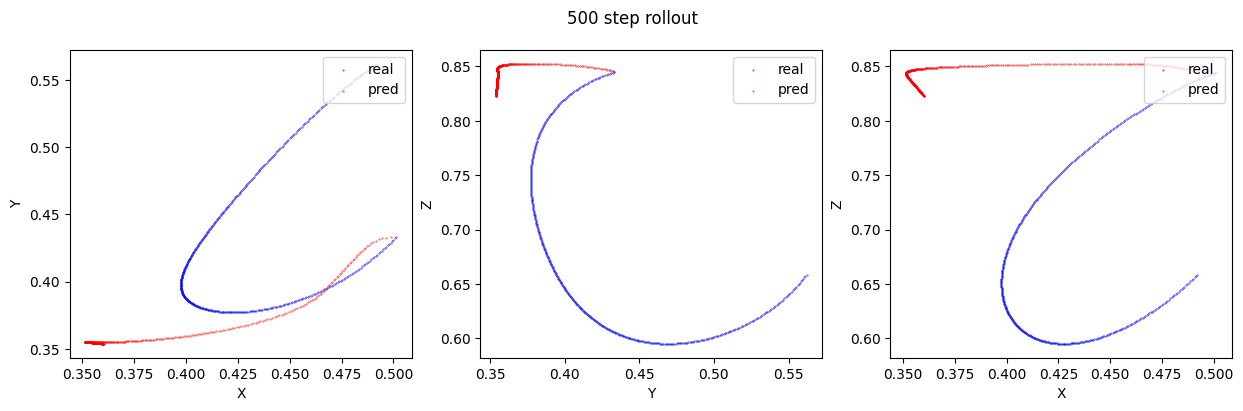

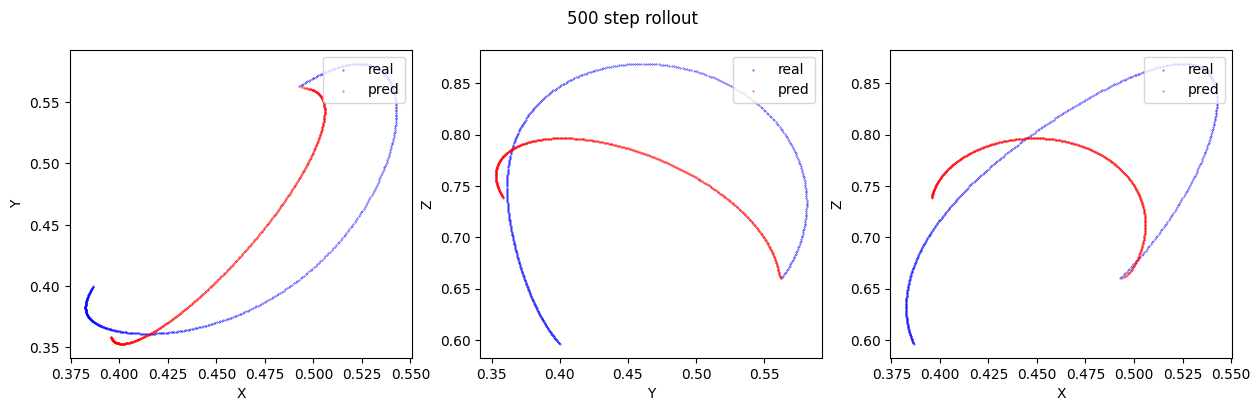

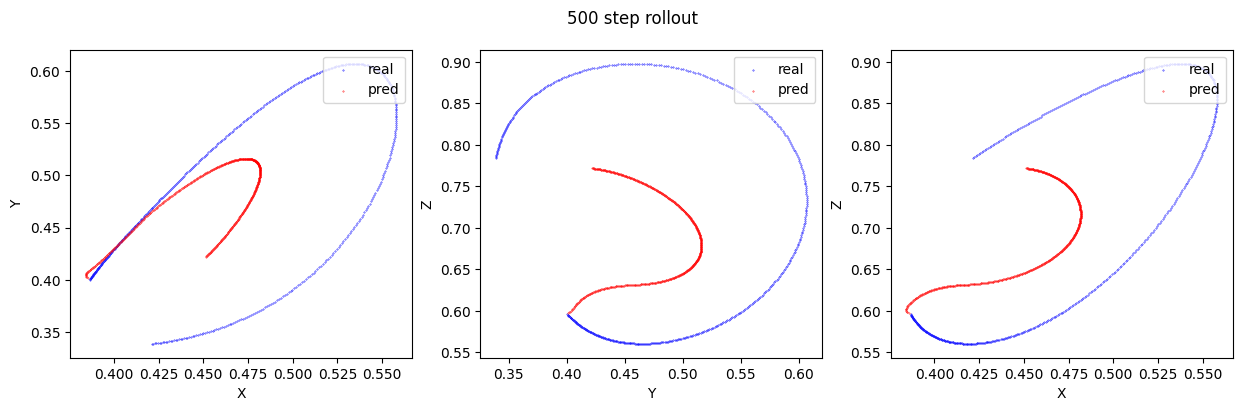

In [114]:
n = 500
offset = 500

for i in range(3):
    preds = n_step_rollout(model, n, positions[i * 500])
    compare_trajectories(positions[i * offset:i * offset + n], preds, f"{n} step rollout", "real", "pred")

  0%|          | 0/100000 [00:00<?, ?it/s]

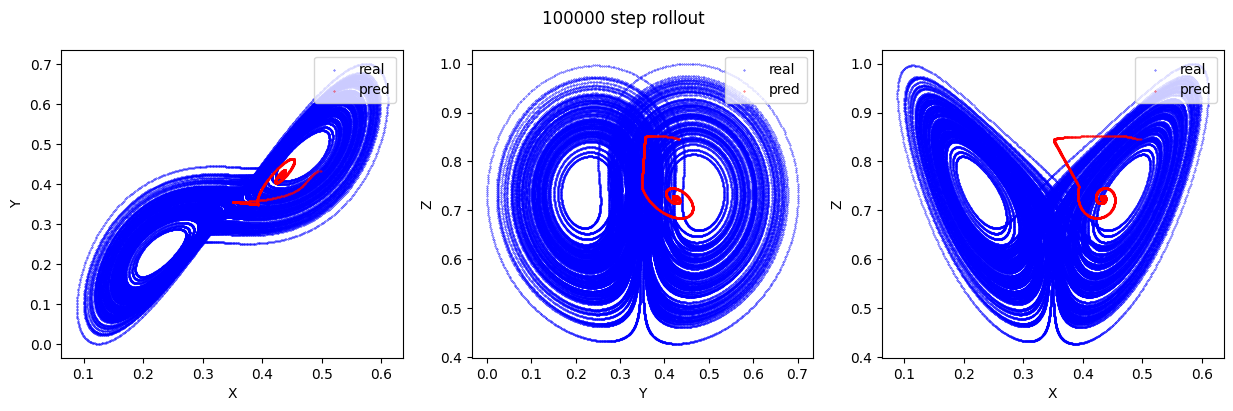

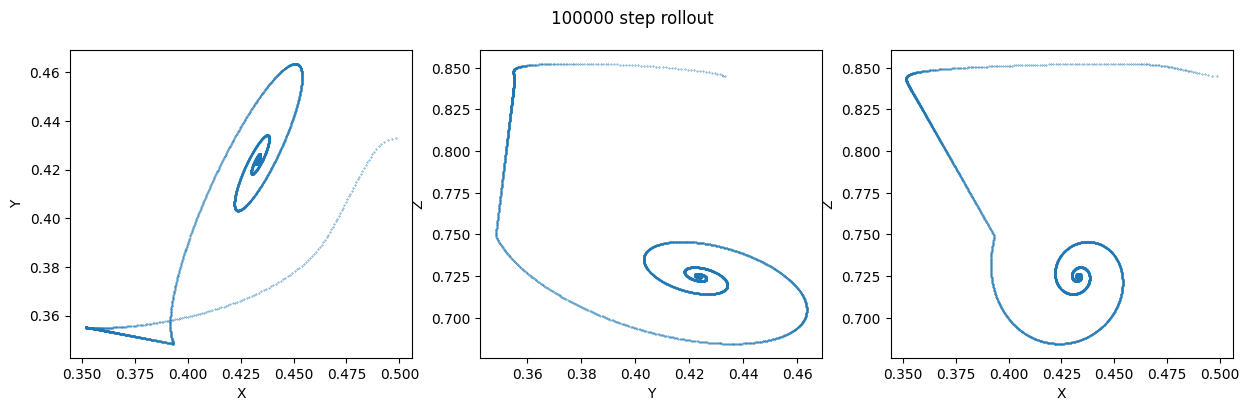

In [115]:
n=100_000
preds = n_step_rollout(model, n, positions[0])
compare_trajectories(positions[:n], preds, f"{n} step rollout", "real", "pred")
plot_xyz(preds, f"{n} step rollout")